# 04. 주별 분석 (State Analysis)

각 주(State)별 성격 척도 점수를 분석하고 Critical Ratios를 계산합니다.

## 학습 목표
- 주별 기술통계 계산 (N, Mean, SE)
- Critical Ratios 계산: CR = (State Mean - Grand Mean) / SE
- 유의미한 주별 특징 식별 (|CR| > 3.0, p < .003)
- 주별 특징 히트맵 시각화


In [1]:
# 필요한 라이브러리 설치 (처음 한 번만 실행)
%pip install pandas numpy matplotlib seaborn scipy -q



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

# 상위 폴더로 이동해서 데이터 접근
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(f'작업 폴더: {os.getcwd()}')


작업 폴더: /Users/serinoh/serin-oh/safa


## 1. 데이터 준비

점수 데이터와 원본 데이터를 병합하여 state 정보를 추가합니다.


In [3]:
# 점수 데이터 로드
scores = pd.read_csv('data/processed/sapa_scores.csv')

# 원본 데이터에서 state 정보 가져오기
raw_data = pd.read_csv('data/raw/sapa_data.csv', usecols=['RID', 'state', 'country'])

# 병합
df = scores.merge(raw_data[['RID', 'state', 'country']], on='RID', how='left')

print(f'병합 후 데이터 크기: {df.shape}')
print(f'\nState 변수 분포:')
print(df['state'].value_counts().head(20))


병합 후 데이터 크기: (23647, 15)

State 변수 분포:
state
other           16339
California       1713
Michigan          860
Illinois          820
Texas             711
Pennsylvania      700
Florida           696
New York          684
Washington        599
Virginia          525
Name: count, dtype: int64


In [4]:
# 분석 대상 척도
scale_cols = [
    'NEO_Openness',
    'NEO_Conscientiousness',
    'NEO_Extraversion',
    'NEO_Agreeableness',
    'NEO_Neuroticism',
    'Ideology',
    'Honesty_Humility'
]

# 필터링: USA만, state가 "other"가 아닌 경우
df_usa = df[(df['country'] == 'USA') & (df['state'] != 'other')].copy()

print(f'필터링 후 데이터 크기: {df_usa.shape}')
print(f'\n유효한 State 수: {df_usa["state"].nunique()}개')
print(f'\nState별 표본 수:')
state_counts = df_usa['state'].value_counts().sort_values(ascending=False)
print(state_counts)


필터링 후 데이터 크기: (7308, 15)

유효한 State 수: 9개

State별 표본 수:
state
California      1713
Michigan         860
Illinois         820
Texas            711
Pennsylvania     700
Florida          696
New York         684
Washington       599
Virginia         525
Name: count, dtype: int64


## 2. 주별 기술통계 계산

각 주(State)와 척도별로 N, Mean, SE를 계산합니다.


In [5]:
# 주별 기술통계 계산
def calculate_state_stats(df, scale_cols):
    """각 주별로 척도 통계 계산"""
    results = []
    
    for state in df['state'].unique():
        state_data = df[df['state'] == state]
        
        for scale in scale_cols:
            values = state_data[scale].dropna()
            
            if len(values) > 0:
                results.append({
                    'State': state,
                    'Scale': scale,
                    'N': len(values),
                    'Mean': values.mean(),
                    'SD': values.std(),
                    'SE': values.std() / np.sqrt(len(values)) if len(values) > 1 else np.nan
                })
    
    return pd.DataFrame(results)

state_stats = calculate_state_stats(df_usa, scale_cols)
print(f'계산된 통계: {len(state_stats)}개 (State × Scale 조합)')
print('\n=== 주별 기술통계 샘플 ===')
print(state_stats.head(10))


계산된 통계: 63개 (State × Scale 조합)

=== 주별 기술통계 샘플 ===
      State                  Scale    N      Mean        SD        SE
0  Illinois           NEO_Openness  814  4.248810  0.860467  0.030159
1  Illinois  NEO_Conscientiousness  820  4.349521  0.837561  0.029249
2  Illinois       NEO_Extraversion  812  4.069677  0.907063  0.031832
3  Illinois      NEO_Agreeableness  817  4.305878  0.789969  0.027638
4  Illinois        NEO_Neuroticism  814  3.222407  0.946906  0.033189
5  Illinois               Ideology  411  0.147000  0.960128  0.047360
6  Illinois       Honesty_Humility  460  0.022018  0.708106  0.033016
7  New York           NEO_Openness  680  4.394886  0.805263  0.030880
8  New York  NEO_Conscientiousness  678  4.230819  0.857416  0.032929
9  New York       NEO_Extraversion  677  3.932596  0.891964  0.034281


In [6]:
# 전체 평균 (Grand Mean) 계산
grand_means = {}
for scale in scale_cols:
    values = df_usa[scale].dropna()
    if len(values) > 0:
        grand_means[scale] = values.mean()

print('=== 전체 평균 (Grand Mean) ===')
for scale, mean_val in grand_means.items():
    print(f'{scale}: {mean_val:.3f}')


=== 전체 평균 (Grand Mean) ===
NEO_Openness: 4.275
NEO_Conscientiousness: 4.294
NEO_Extraversion: 3.953
NEO_Agreeableness: 4.290
NEO_Neuroticism: 3.321
Ideology: 0.119
Honesty_Humility: 0.063


## 3. Critical Ratios 계산

Critical Ratio = (State Mean - Grand Mean) / SE

|CR| > 3.0인 경우 유의미한 특징으로 간주합니다 (p < .003).


In [7]:
# Critical Ratios 계산
state_stats['Grand_Mean'] = state_stats['Scale'].map(grand_means)
state_stats['CR'] = (state_stats['Mean'] - state_stats['Grand_Mean']) / state_stats['SE']
state_stats['abs_CR'] = state_stats['CR'].abs()

# 유의미한 특징 식별 (|CR| > 3.0)
significant = state_stats[state_stats['abs_CR'] > 3.0].copy()
significant = significant.sort_values('abs_CR', ascending=False)

print(f'유의미한 특징 수 (|CR| > 3.0): {len(significant)}개')
print('\n=== 유의미한 주별 특징 (상위 20개) ===')
print(significant[['State', 'Scale', 'Mean', 'Grand_Mean', 'SE', 'CR']].head(20).to_string(index=False))


유의미한 특징 수 (|CR| > 3.0): 8개

=== 유의미한 주별 특징 (상위 20개) ===
     State             Scale      Mean  Grand_Mean       SE        CR
  Michigan  Honesty_Humility  0.201396    0.063373 0.032056  4.305753
  New York      NEO_Openness  4.394886    4.275382 0.030880  3.869897
  Illinois  NEO_Extraversion  4.069677    3.953343 0.031832  3.654690
  Michigan NEO_Agreeableness  4.380045    4.290150 0.026908  3.340820
   Florida   NEO_Neuroticism  3.196452    3.321213 0.038717 -3.222328
  Michigan      NEO_Openness  4.185835    4.275382 0.027825 -3.218221
California  Honesty_Humility -0.009006    0.063373 0.022563 -3.207901
California          Ideology  0.016977    0.119082 0.032882 -3.105208


In [8]:
# 방향성 추가 (높음/낮음)
significant['Direction'] = significant['CR'].apply(lambda x: 'High' if x > 0 else 'Low')

print('\n=== 주별 유의미한 특징 요약 ===')
summary = significant.groupby(['State', 'Direction']).size().reset_index(name='Count')
summary_pivot = summary.pivot(index='State', columns='Direction', values='Count').fillna(0)
print(summary_pivot)



=== 주별 유의미한 특징 요약 ===
Direction   High  Low
State                
California   0.0  2.0
Florida      0.0  1.0
Illinois     1.0  0.0
Michigan     2.0  1.0
New York     1.0  0.0


## 4. Critical Ratios 히트맵 시각화

주별 Critical Ratios를 히트맵으로 시각화합니다.


In [9]:
# 히트맵용 데이터 준비 (State × Scale)
cr_matrix = state_stats.pivot(index='State', columns='Scale', values='CR')

# 표본 수가 적은 주 제외 (선택적: N < 10인 경우)
state_n = df_usa.groupby('state').size()
valid_states = state_n[state_n >= 10].index
cr_matrix_filtered = cr_matrix.loc[cr_matrix.index.isin(valid_states)]

print(f'히트맵에 포함된 주 수: {len(cr_matrix_filtered)}개')
print(f'척도 수: {len(cr_matrix_filtered.columns)}개')


히트맵에 포함된 주 수: 9개
척도 수: 7개


저장 완료: reports/figures/state_critical_ratios_heatmap.png


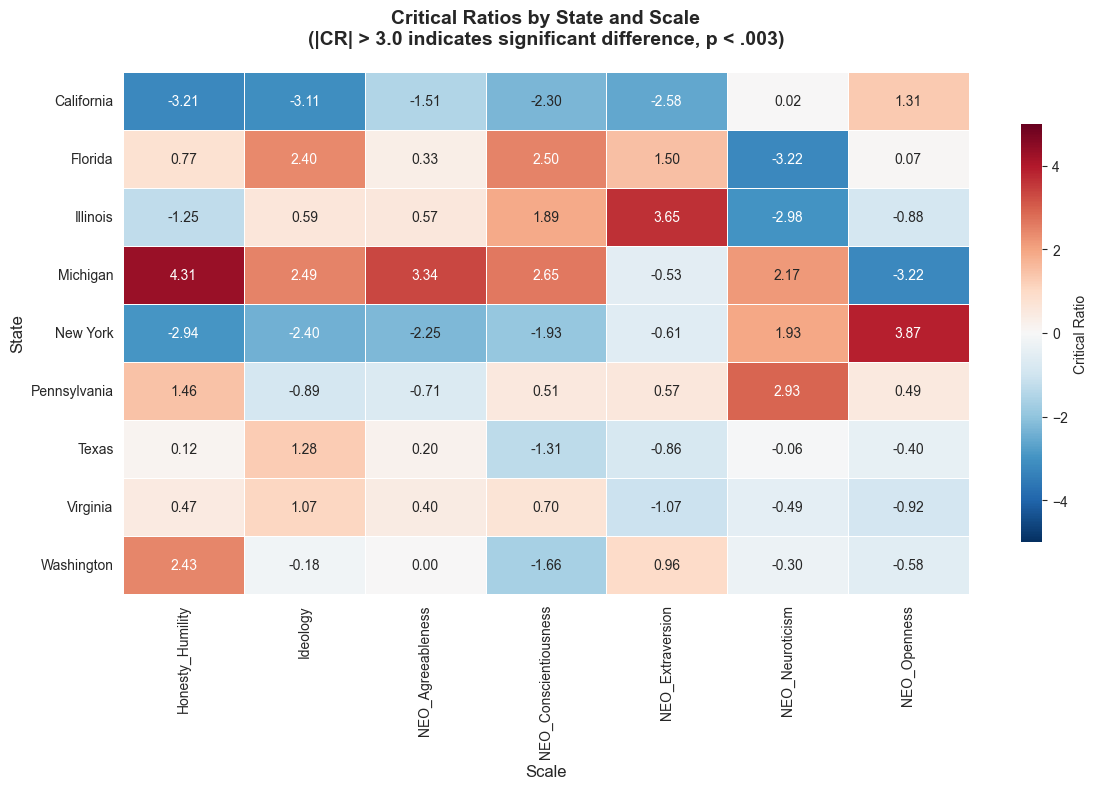

In [10]:
# Critical Ratios 히트맵 생성
fig, ax = plt.subplots(figsize=(12, max(8, len(cr_matrix_filtered) * 0.3)))

# 히트맵 그리기
sns.heatmap(cr_matrix_filtered,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-5,
            vmax=5,
            linewidths=0.5,
            cbar_kws={"label": "Critical Ratio", "shrink": 0.8},
            ax=ax)

plt.title('Critical Ratios by State and Scale\n(|CR| > 3.0 indicates significant difference, p < .003)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Scale', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()

# 저장
os.makedirs('reports/figures', exist_ok=True)
plt.savefig('reports/figures/state_critical_ratios_heatmap.png', dpi=300, bbox_inches='tight')
print('저장 완료: reports/figures/state_critical_ratios_heatmap.png')
plt.show()


## 5. 주별 표본 수 요약

각 주의 표본 수를 확인합니다.


In [11]:
# 주별 표본 수
state_sample_sizes = df_usa.groupby('state').size().sort_values(ascending=False)
state_sample_sizes_df = pd.DataFrame({
    'State': state_sample_sizes.index,
    'N': state_sample_sizes.values
})

print('=== 주별 표본 수 ===')
print(state_sample_sizes_df.to_string(index=False))
print(f'\n총 주 수: {len(state_sample_sizes_df)}개')
print(f'평균 표본 수: {state_sample_sizes_df["N"].mean():.1f}명')
print(f'중앙값 표본 수: {state_sample_sizes_df["N"].median():.1f}명')


=== 주별 표본 수 ===
       State    N
  California 1713
    Michigan  860
    Illinois  820
       Texas  711
Pennsylvania  700
     Florida  696
    New York  684
  Washington  599
    Virginia  525

총 주 수: 9개
평균 표본 수: 812.0명
중앙값 표본 수: 700.0명


## 6. 결과 저장

주별 분석 결과를 CSV 파일로 저장합니다.


In [12]:
# 결과 저장
os.makedirs('reports', exist_ok=True)

# 전체 통계 저장
state_stats.to_csv('reports/state_statistics.csv', index=False)
print('저장 완료: reports/state_statistics.csv')

# 유의미한 특징만 저장
significant.to_csv('reports/state_significant_features.csv', index=False)
print('저장 완료: reports/state_significant_features.csv')

# 주별 표본 수 저장
state_sample_sizes_df.to_csv('reports/state_sample_sizes.csv', index=False)
print('저장 완료: reports/state_sample_sizes.csv')

print(f'\n=== 요약 ===')
print(f'분석된 주 수: {df_usa["state"].nunique()}개')
print(f'분석된 척도 수: {len(scale_cols)}개')
print(f'유의미한 특징 수 (|CR| > 3.0): {len(significant)}개')


저장 완료: reports/state_statistics.csv
저장 완료: reports/state_significant_features.csv
저장 완료: reports/state_sample_sizes.csv

=== 요약 ===
분석된 주 수: 9개
분석된 척도 수: 7개
유의미한 특징 수 (|CR| > 3.0): 8개
